<a href="https://www.kaggle.com/code/santruptibehera/verifier?scriptVersionId=175935631" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

df = pd.read_csv('/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv', low_memory=False)

# Pre-defined Functions

## Getting null values

In [27]:
def get_missing(df):
    df_types = pd.DataFrame()
    df_types['data_type'] = df.dtypes
    df_types['missing_values'] = df.isnull().sum()
    return df_types.sort_values(by='missing_values', ascending=False)


## Evaluation Metrics

In [28]:
def precision(actual, predicted):
    # Precision = True pos out of the actual results
    
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FP = np.count_nonzero(np.logical_and((actual == 0) , (predicted == 1)).astype(int))
    return TP/(TP + FP)
def recall(actual, predicted):
    # Recall = True pos out of the predicted results
    
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FN = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 0)).astype(int))
    return TP/(TP + FN)
def f_score(actual , predicted):
    
    P = precision(actual, predicted)
    R = recall(actual, predicted)
    return 2*P*R/(P + R)

# Data Preprocessing

In [29]:
get_missing(df)

,data_type,missing_values
frame.time,object,0
mqtt.conflags,float64,0
tcp.srcport,object,0
udp.port,float64,0
udp.stream,float64,0
...,...,...
tcp.connection.synack,float64,0
tcp.dstport,float64,0
tcp.flags,float64,0
tcp.flags.ack,float64,0


In [30]:
from sklearn.utils import shuffle

df.drop_duplicates(inplace=True)
df = shuffle(df,random_state=20)

df.head(10)

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
10373,2021 23:51:43.908859000,192.168.0.170,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Ransomware
19704,2021 23:12:17.436551000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Uploading
52931,2021 19:09:58.404060000,192.168.0.128,176.174.25.46,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_TCP
35524,2021 11:36:14.082257000,192.168.0.170,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_HTTP
16164,2021 23:11:46.039915000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Uploading
23021,2021 23:16:06.497659000,192.168.0.170,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Uploading
134301,228.131.154.6,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_UDP
5720,2021 22:55:13.431216000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Ransomware
143416,167.164.101.219,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_UDP
43876,2021 11:39:16.898450000,192.168.0.170,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_HTTP


In [31]:
df.describe(include='object')

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.src.proto_ipv4,http.file_data,http.request.uri.query,http.request.method,http.referer,http.request.full_uri,http.request.version,tcp.options,tcp.payload,tcp.srcport,dns.qry.name.len,mqtt.conack.flags,mqtt.msg,mqtt.protoname,mqtt.topic,Attack_type
count,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986,156986
unique,155186,19090,8084,8,8,496,1665,6,4,4073,8,73139,27369,32186,8,3,117,3,3,15
top,192.168.0.128,192.168.0.128,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,80.0,0.0,0.0,0.0,0.0,0.0,Normal
freq,1402,72543,75373,153610,140514,116308,136599,95728,126297,95728,95328,49914,75013,34437,132458,132685,132685,132685,132685,24301


# Data Validation

In [32]:
print(df['frame.time'].value_counts().head())

print("\nNull Values:")
print(df['frame.time'].isna().sum())

frame.time
192.168.0.128                1402
0.0                           394
6.0                             6
 2021 23:12:11.894359000        2
 2021 23:23:31.778361000        1
Name: count, dtype: int64

Null Values:
0


Iconsistent frame.time values

In [33]:
value_counts = df['Attack_label'].value_counts()
ratio = value_counts.get(1, 0) / value_counts.get(0, 0)
print("\nMalware:Normal ratio is", ratio)


Malware:Normal ratio is 5.4600633718777


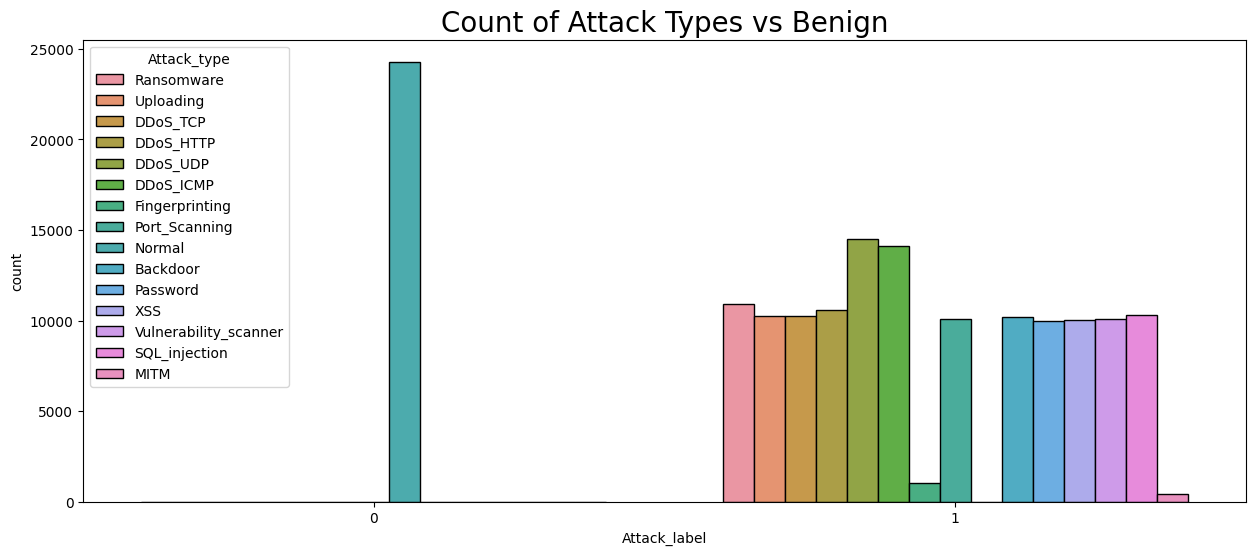

In [34]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Attack_label', hue='Attack_type', edgecolor='black', linewidth=1)
plt.title('Count of Attack Types vs Benign', fontsize=20)
plt.show()

In [35]:
import plotly.express as px
fig = px.pie(df, names='Attack_type', title='Distribution of Attack Types')
fig.show()

In [36]:
# evaluates the relationship between two variables in a data set
numeric_cols = df.select_dtypes(include='number').columns
numeric_data = df[numeric_cols]

# correlation coefficient = 1: a strong relationship, 0 a neutral relationship, -1 a not strong relationship
numeric_data.corr()

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,...,mqtt.len,mqtt.msg_decoded_as,mqtt.msgtype,mqtt.proto_len,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label
arp.opcode,1.000000,0.944177,-0.026054,-0.027067,-0.002185,NaN,-0.006104,-0.020861,NaN,-0.021998,...,-0.011077,NaN,-0.011883,-0.008513,-0.008499,-0.008513,NaN,NaN,NaN,0.035270
arp.hw.size,0.944177,1.000000,-0.027595,-0.028667,-0.002315,NaN,-0.006465,-0.022095,NaN,-0.023298,...,-0.011732,NaN,-0.012585,-0.009016,-0.009002,-0.009016,NaN,NaN,NaN,0.035645
icmp.checksum,-0.026054,-0.027595,1.000000,0.681791,0.056323,NaN,-0.017615,-0.060200,NaN,-0.063480,...,-0.031965,NaN,-0.034291,-0.024566,-0.024526,-0.024566,NaN,NaN,NaN,0.117346
icmp.seq_le,-0.027067,-0.028667,0.681791,1.000000,-0.006552,NaN,-0.018300,-0.062539,NaN,-0.065946,...,-0.033207,NaN,-0.035623,-0.025520,-0.025479,-0.025520,NaN,NaN,NaN,0.121905
icmp.transmit_timestamp,-0.002185,-0.002315,0.056323,-0.006552,1.000000,NaN,-0.001478,-0.005050,NaN,-0.005325,...,-0.002681,NaN,-0.002876,-0.002061,-0.002057,-0.002061,NaN,NaN,NaN,0.009843
icmp.unused,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
http.content_length,-0.006104,-0.006465,-0.017615,-0.018300,-0.001478,NaN,1.000000,0.267459,NaN,-0.014871,...,-0.007489,NaN,-0.008034,-0.005755,-0.005746,-0.005755,NaN,NaN,NaN,0.027493
http.response,-0.020861,-0.022095,-0.060200,-0.062539,-0.005050,NaN,0.267459,1.000000,NaN,-0.050822,...,-0.025594,NaN,-0.027456,-0.019669,-0.019638,-0.019669,NaN,NaN,NaN,0.093958
http.tls_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tcp.ack,-0.021998,-0.023298,-0.063480,-0.065946,-0.005325,NaN,-0.014871,-0.050822,NaN,1.000000,...,-0.026988,NaN,-0.028952,-0.020741,-0.020707,-0.020741,NaN,NaN,NaN,0.091726


# Before Dimensionality Reduction

In [37]:
label_encoder = LabelEncoder()
df['Attack_label'] = label_encoder.fit_transform(df['Attack_label'])

df['Attack_label'].value_counts()

Attack_label
1    132685
0     24301
Name: count, dtype: int64

In [38]:
from imblearn.over_sampling import SMOTE

numeric_cols = df.select_dtypes(include='number').columns
X = df[numeric_cols].drop(['Attack_label'], axis=1)
y_label = df['Attack_label']
y_type = df['Attack_type']


X_train, X_test, y_train_label, y_test_label = train_test_split(X, y_label, test_size=0.2, random_state=42)

# up-sampling minority classes while avoiding overfitting by generating new synthetic examples close to the minority class in feature space.
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_label_resampled = smote.fit_resample(X_train, y_train_label)
X_test_resampled, y_test_label_resampled = smote.fit_resample(X_test, y_test_label)

In [39]:
print(y_train_label.value_counts())
print(y_train_label_resampled.value_counts())

Attack_label
1    106102
0     19486
Name: count, dtype: int64
Attack_label
1    106102
0    106102
Name: count, dtype: int64


# Dimensionality Reduction with Fisher's LDA

In [40]:
# Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_resampled = lda.fit_transform(X_train_resampled, y_train_label_resampled)
X_test_resampled = lda.transform(X_test_resampled)

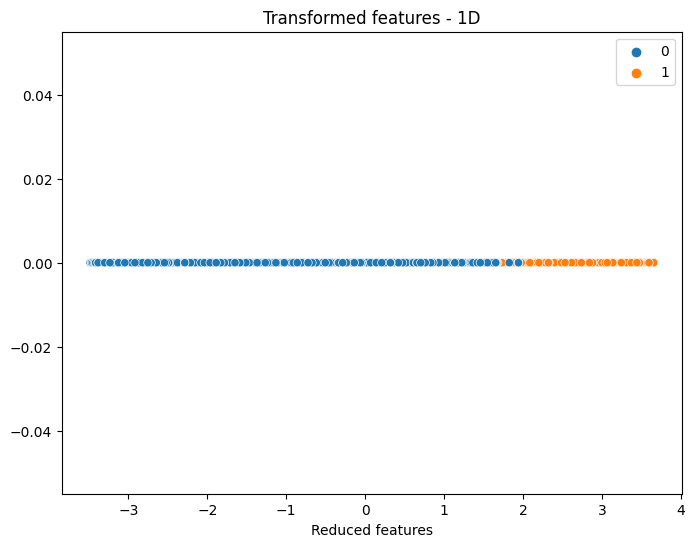

In [41]:
# Visualise using a scatter plot the DataFrame with the transformed feature and the class labels
tmp_df = pd.DataFrame(X_train_resampled, columns=['Reduced features'])
tmp_df['Attack_label'] = y_train_label_resampled

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tmp_df, x='Reduced features', y=np.zeros_like(tmp_df['Reduced features']), hue='Attack_label')

plt.legend(loc='upper right')
plt.title('Transformed features - 1D')
plt.show()

# Attack Prediction - Binary Classification

## Decision Tree

In [42]:
#LDA model evaluation with decision-tree

dt = DecisionTreeClassifier()
dt.fit(X_train_resampled, y_train_label_resampled)
y_pred1 = dt.predict(X_test_resampled)

Accuracy: 0.74
F-score: 0.74


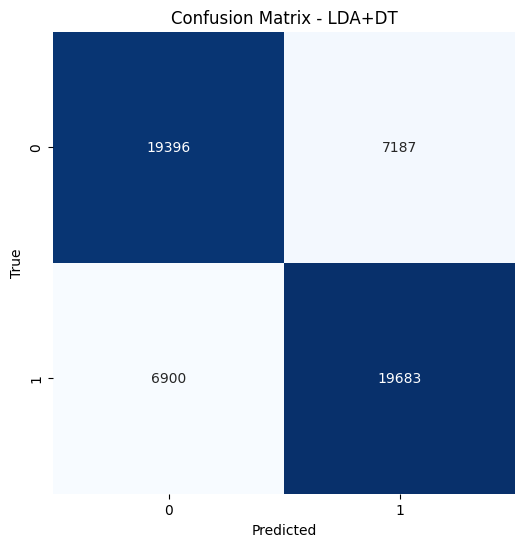

In [43]:
#Evaluation metrics
accuracy = accuracy_score(y_test_label_resampled, y_pred1)
fscore = f_score(y_test_label_resampled , y_pred1)
conf_m = confusion_matrix(y_test_label_resampled, y_pred1)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LDA+DT")
plt.show()


## HyperParamter Tuning for DT

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Scores: 0.7907249807189227
Accuracy: 0.74
F-score: 0.74


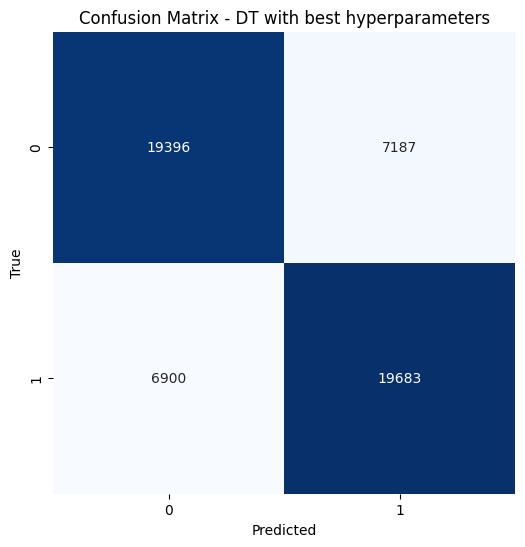

In [44]:
# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt, param_grid, cv=5,n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new DecisionTreeClassifier model with the best hyperparameters
dt_best = DecisionTreeClassifier(**best_params)
dt_best.fit(X_train_resampled, y_train_label_resampled)
y_pred = dt_best.predict(X_test_resampled)

#Evaluation metrics
accuracy = accuracy_score(y_test_label_resampled, y_pred1)
fscore = f_score(y_test_label_resampled , y_pred1)
conf_m = confusion_matrix(y_test_label_resampled, y_pred1)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - DT with best hyperparameters")
plt.show()

## Random Forest

In [45]:
#LDA model evaluation with random-forest

rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train_resampled, y_train_label_resampled)
y_pred2 = rf.predict(X_test_resampled)

Accuracy: 0.78
F-score: 0.75


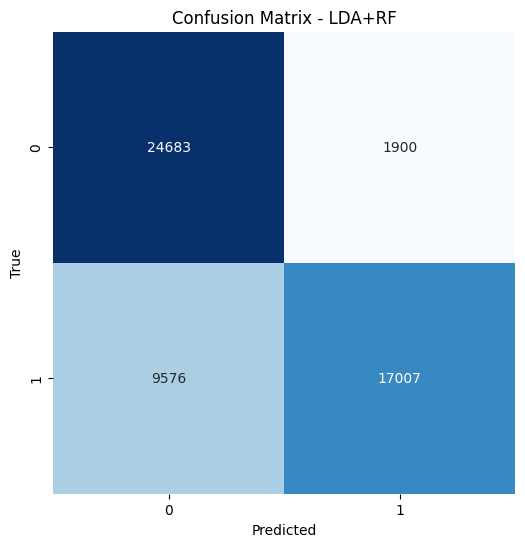

In [46]:
#Evaluation metrics
accuracy = accuracy_score(y_test_label_resampled, y_pred2)
fscore = f_score(y_test_label_resampled, y_pred2)
conf_m = confusion_matrix(y_test_label_resampled, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LDA+RF")
plt.show()

## Hyper Parameter Tuning for RF

Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Best Scores: 0.7907438357459413
Accuracy: 0.78
F-score: 0.75


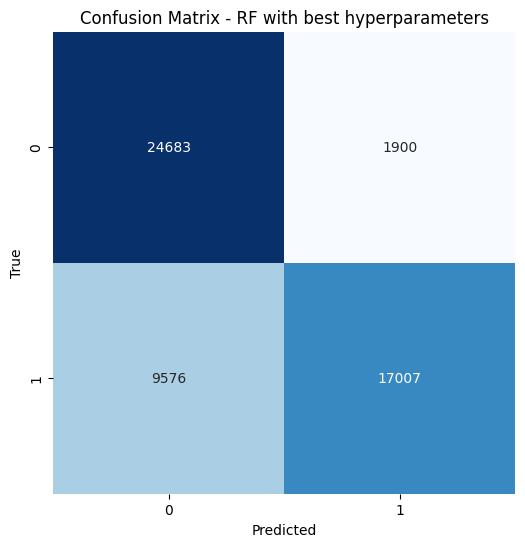

In [47]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new RandomForestClassifier model with the best hyperparameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train_resampled, y_train_label_resampled)
y_pred = rf_best.predict(X_test_resampled)

#Evaluation metrics
accuracy = accuracy_score(y_test_label_resampled, y_pred2)
fscore = f_score(y_test_label_resampled, y_pred2)
conf_m = confusion_matrix(y_test_label_resampled, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RF with best hyperparameters")
plt.show()

## Naive Bayes

In [48]:
#LDA model evaluation with Naive Bayes

nb = GaussianNB()
nb.fit(X_train_resampled, y_train_label_resampled)
y_pred3 = nb.predict(X_test_resampled)

Accuracy: 0.77
F-score: 0.77


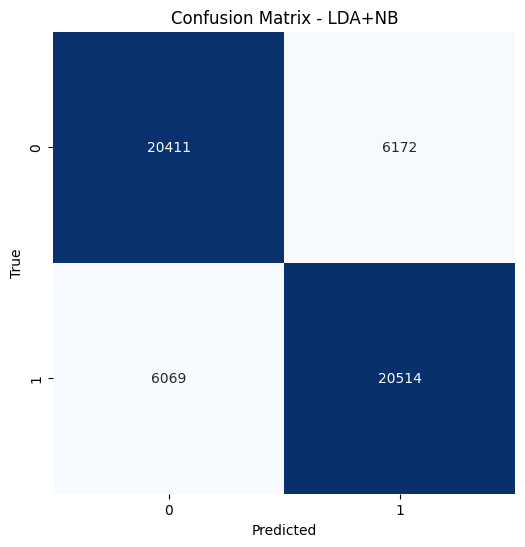

In [49]:
#Evaluation metrics
accuracy = accuracy_score(y_test_label_resampled, y_pred3)
fscore = f_score(y_test_label_resampled, y_pred3)
conf_m = confusion_matrix(y_test_label_resampled, y_pred3)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LDA+NB")
plt.show()

## Hyper Parameter Tuning for NB

Best Parameters: {'var_smoothing': 1.0}
Best Scores: 0.7673371304991321
Accuracy: 0.77
F-score: 0.77


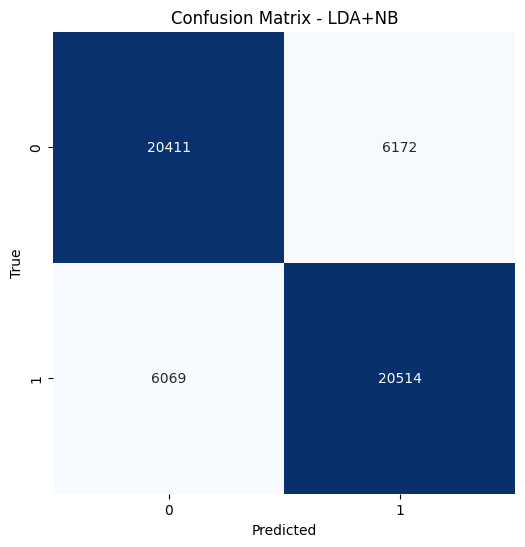

In [51]:
# Define the hyperparameters to tune
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_search = GridSearchCV(nb, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new RandomForestClassifier model with the best hyperparameters
nb_best = GaussianNB(**best_params)
nb_best.fit(X_train_resampled, y_train_label_resampled)
y_pred = nb_best.predict(X_test_resampled)

#Evaluation metrics
accuracy = accuracy_score(y_test_label_resampled, y_pred3)
fscore = f_score(y_test_label_resampled, y_pred3)
conf_m = confusion_matrix(y_test_label_resampled, y_pred3)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LDA+NB")
plt.show()

# Attack Type Prediction - MultiLabel classification

In [53]:
from imblearn.over_sampling import SMOTE

numeric_cols = df.select_dtypes(include='number').columns
X = df[numeric_cols].drop(['Attack_label'], axis=1)
y_label = df['Attack_label']
y_type = df['Attack_type']

X_train, X_test, y_train_type, y_test_type = train_test_split(X, y_type, test_size=0.2, random_state=42)

# Label Encoding
label_encoder = LabelEncoder()
y_train_type =  label_encoder.fit_transform(y_train_type)
y_test_type = label_encoder.transform(y_test_type)

# up-sampling minority classes while avoiding overfitting by generating new synthetic examples close to the minority class in feature space.
smote = SMOTE(sampling_strategy='auto')
X_train_resampled, y_train_type_resampled = smote.fit_resample(X_train, y_train_type)
X_test_resampled, y_test_type_resampled = smote.fit_resample(X_test, y_test_type)


In [54]:
from sklearn.preprocessing import MinMaxScaler
from  tensorflow.keras.utils import to_categorical

min_max_scaler = MinMaxScaler()
X_train_resampled =  min_max_scaler.fit_transform(X_train_resampled)
X_test_resampled = min_max_scaler.transform(X_test_resampled)

In [55]:
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_resampled = X_test_resampled.reshape(X_test_resampled.shape[0], X_test_resampled.shape[1], 1)

count = len(np.unique(y_train_type_resampled))
y_train_type_resampled = to_categorical(y_train_type_resampled, num_classes=count)
y_test_type_resampled = to_categorical(y_test_type_resampled, num_classes=count)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
input_shape = X_train_resampled.shape[1:]
model.add(Conv1D(32, 3, activation='relu', input_shape=(input_shape)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu', input_shape=(input_shape)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(count, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 128)            24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 3, 128)            0

In [57]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Input, ZeroPadding1D
from tensorflow.keras.layers import MaxPooling1D, Add, AveragePooling1D
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam 

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss= tf.keras.metrics.categorical_crossentropy, 
                  metrics=['accuracy'])

In [58]:
from sklearn.metrics import accuracy_score

#Evaluation metrics
y_pred = model.predict(X_test_resampled)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_type_resampled, axis=1)

# accuracy = accuracy_score(y_true, y_pred)
# # fscore = f_score(y_true, y_pred)
# # conf_m = confusion_matrix(y_true, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# # print(f'F-score: {fscore:.2f}') 

# # plt.figure(figsize=(10, 5))
# # sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
# # plt.xlabel("Predicted")
# # plt.ylabel("True")
# # plt.title("Confusion Matrix - CNN")
# # plt.show()

2258/2258 [==============================] - 7s 3ms/step
